# Titanic - Top 3 Models Ensemble (CatBoost + XGBoost + RandomForest)

このノートブックは、CatBoost, XGBoost, RandomForestの3モデルアンサンブルです。

## 目次
1. セットアップとデータ読み込み
2. 特徴量エンジニアリング
3. 最適なハイパーパラメータ設定
4. Stratified K-Fold学習
5. アンサンブル予測と提出
6. Feature Importance分析

## 1. セットアップとデータ読み込み

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import string
import pickle
from typing import Dict, List, Tuple
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# 定数設定
RANDOM_STATE = 42
N_FOLDS = 5

# 乱数シード固定
np.random.seed(RANDOM_STATE)

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [2]:
# データ読み込み
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nTarget distribution:")
print(df_train['Perished'].value_counts(normalize=True))

df_train.head()

Train shape: (891, 12)
Test shape: (418, 11)

Target distribution:
Perished
1    0.616162
0    0.383838
Name: proportion, dtype: float64


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. 特徴量エンジニアリング

In [3]:
def extract_surname(data):
    """名前から姓を抽出"""
    families = []
    
    for i in range(len(data)):
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name
        
        family = name_no_bracket.split(',')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        
        families.append(family)
    
    return families


def create_features(df_train, df_test):
    """
    特徴量エンジニアリングを実行（データリークなし）
    """
    train = df_train.copy()
    test = df_test.copy()
    
    all_data = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
    
    print("特徴量エンジニアリング開始...")
    
    # 1. Title（敬称）抽出
    all_data['Title'] = all_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    all_data['Title'] = all_data['Title'].replace(
        ['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms'
    )
    all_data['Title'] = all_data['Title'].replace(
        ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy'
    )
    
    # 2. 結婚フラグ
    all_data['Is_Married'] = 0
    all_data.loc[all_data['Title'] == 'Mrs', 'Is_Married'] = 1
    
    # 3. Family（姓）
    all_data['Family'] = extract_surname(all_data['Name'])
    
    # 4. Family_Size（家族サイズ）
    all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1
    
    # 5. Family_Size_Grouped（家族サイズのビン化）
    family_map = {
        1: 'Alone',
        2: 'Small', 3: 'Small', 4: 'Small',
        5: 'Medium', 6: 'Medium',
        7: 'Large', 8: 'Large', 11: 'Large'
    }
    all_data['Family_Size_Grouped'] = all_data['Family_Size'].map(family_map)
    
    # 6. Ticket_Frequency（チケット頻度）
    all_data['Ticket_Frequency'] = all_data.groupby('Ticket')['Ticket'].transform('count')
    
    # 7. Deck（デッキ）
    all_data['Deck'] = all_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    all_data['Deck'] = all_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
    all_data['Deck'] = all_data['Deck'].replace(['D', 'E'], 'DE')
    all_data['Deck'] = all_data['Deck'].replace(['F', 'G'], 'FG')
    all_data['Deck'] = all_data['Deck'].replace(['T'], 'M')
    
    # 8. Age補完と離散化
    all_data['Age'] = pd.to_numeric(all_data['Age'], errors='coerce')
    age_by_pclass_sex = all_data.groupby(['Sex', 'Pclass'])['Age'].median()
    
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            mask = (all_data['Age'].isnull()) & (all_data['Pclass'] == pclass) & (all_data['Sex'] == sex)
            all_data.loc[mask, 'Age'] = age_by_pclass_sex.loc[(sex, pclass)]
    
    all_data['Age_Band'] = pd.cut(all_data['Age'], bins=[0, 12, 18, 30, 50, 80], 
                                    labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # 9. Fare補完と離散化（訓練データのみから統計量を計算）
    train_idx = ~all_data['Perished'].isna()
    
    train_fare_median = all_data.loc[train_idx, 'Fare'].median()
    all_data['Fare'] = all_data['Fare'].fillna(train_fare_median)
    
    train_fare_quantiles = all_data.loc[train_idx, 'Fare'].quantile([0.25, 0.5, 0.75]).values
    all_data['Fare_Band'] = pd.cut(
        all_data['Fare'],
        bins=[-np.inf] + train_fare_quantiles.tolist() + [np.inf],
        labels=['Low', 'Medium', 'High', 'Very_High']
    )
    
    # 10. Embarked補完
    all_data['Embarked'] = all_data['Embarked'].fillna('S')
    
    # 11. Sex x Pclass 交互作用
    all_data['Sex_Pclass'] = all_data['Sex'] + '_' + all_data['Pclass'].astype(str)
    
    print(f"  ✓ 特徴量作成完了: {all_data.shape[1]} columns")
    print(f"  ✓ データリーク特徴量を削除済み")
    
    train_processed = all_data[train_idx].reset_index(drop=True)
    test_processed = all_data[~train_idx].reset_index(drop=True)
    
    return train_processed, test_processed


train_df, test_df = create_features(df_train, df_test)

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

特徴量エンジニアリング開始...
  ✓ 特徴量作成完了: 22 columns
  ✓ データリーク特徴量を削除済み

Train shape: (891, 22)
Test shape: (418, 22)


In [4]:
def prepare_data(train_df, test_df):
    """
    データを機械学習モデル用に準備（データリークなし）
    """
    feature_cols = [
        'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
        'Embarked', 'Title', 'Is_Married', 'Family_Size',
        'Family_Size_Grouped', 'Ticket_Frequency', 'Deck',
        'Age_Band', 'Fare_Band', 'Sex_Pclass'
    ]
    
    train = train_df[feature_cols + ['Perished']].copy()
    test = test_df[feature_cols].copy()
    
    cat_features = ['Sex', 'Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']
    
    le_dict = {}
    for col in cat_features:
        le = LabelEncoder()
        le.fit(train[col].astype(str))
        
        train[col] = le.transform(train[col].astype(str))
        
        test_col_str = test[col].astype(str)
        unknown_mask = ~test_col_str.isin(le.classes_)
        
        if unknown_mask.any():
            most_frequent = train_df[col].mode()[0]
            test.loc[unknown_mask, col] = most_frequent
            print(f"  Warning: {col} has {unknown_mask.sum()} unknown categories in test")
        
        test[col] = le.transform(test[col].astype(str))
        le_dict[col] = le
    
    X = train.drop('Perished', axis=1)
    y = train['Perished']
    X_test = test
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"\n✓ No data leakage")
    
    return X, y, X_test, cat_features


X, y, X_test, cat_features = prepare_data(train_df, test_df)
print(f"\nCategorical features: {cat_features}")

X shape: (891, 16)
y shape: (891,)
X_test shape: (418, 16)

✓ No data leakage

Categorical features: ['Sex', 'Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']


## 3. 最適なハイパーパラメータ設定

In [5]:
# 各モデルの最適なハイパーパラメータ

# RandomForest
best_params_randomforest = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_leaf_nodes': 50,
    'bootstrap': True,
    'max_samples': 0.8,
    'criterion': 'gini',
    'min_impurity_decrease': 0.0,
    'class_weight': 'balanced',
    'ccp_alpha': 0.0,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

# CatBoost
best_params_catboost = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3.0,
    'border_count': 128,
    'random_strength': 1.0,
    'bagging_temperature': 0.5,
    'subsample': 0.8,
    'min_data_in_leaf': 10,
    'max_leaves': 31,
    'leaf_estimation_iterations': 5,
    'random_state': RANDOM_STATE,
    'verbose': 0,
    'task_type': 'CPU'
}

# XGBoost
best_params_xgboost = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 3,
    'gamma': 0.1,
    'max_delta_step': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': 1.0,
    'max_bin': 256,
    'random_state': RANDOM_STATE,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}

print("="*60)
print("最適なハイパーパラメータを設定完了")
print("="*60)
print("\nRandomForest, CatBoost, XGBoost の3モデルを使用")

最適なハイパーパラメータを設定完了

RandomForest, CatBoost, XGBoost の3モデルを使用


## 4. Stratified K-Fold学習

In [6]:
def train_top3_models(X, y, X_test, n_folds=5):
    """
    Top 3モデル（RandomForest, CatBoost, XGBoost）をStratified K-Foldで学習
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # OOF予測とテスト予測を保存
    oof_preds_rf = np.zeros(len(X))
    oof_preds_cat = np.zeros(len(X))
    oof_preds_xgb = np.zeros(len(X))
    
    test_preds_rf = np.zeros((len(X_test), n_folds))
    test_preds_cat = np.zeros((len(X_test), n_folds))
    test_preds_xgb = np.zeros((len(X_test), n_folds))
    
    models_rf = []
    models_cat = []
    models_xgb = []
    
    # 過学習チェック用
    train_scores = {'rf': [], 'cat': [], 'xgb': []}
    valid_scores = {'rf': [], 'cat': [], 'xgb': []}
    
    # 学習曲線データ保存用
    learning_curves = {
        'cat': [],  # CatBoostの学習曲線（各fold）
        'xgb': []   # XGBoostの学習曲線（各fold）
    }
    
    print("="*60)
    print("Stratified K-Fold Training (Top 3 Models)")
    print("="*60)
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f"\n{'='*60}")
        print(f"Fold {fold + 1}/{n_folds}")
        print(f"{'='*60}")
        
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # RandomForest
        print("\n[1/3] Training RandomForest...")
        model_rf = RandomForestClassifier(**best_params_randomforest)
        model_rf.fit(X_train, y_train)
        
        train_preds_rf = model_rf.predict(X_train)
        valid_preds_rf = model_rf.predict(X_valid)
        
        oof_preds_rf[valid_idx] = valid_preds_rf
        test_preds_rf[:, fold] = model_rf.predict(X_test)
        models_rf.append(model_rf)
        
        train_acc_rf = accuracy_score(y_train, train_preds_rf)
        valid_acc_rf = accuracy_score(y_valid, valid_preds_rf)
        train_scores['rf'].append(train_acc_rf)
        valid_scores['rf'].append(valid_acc_rf)
        
        print(f"  Train Accuracy: {train_acc_rf:.4f}")
        print(f"  Valid Accuracy: {valid_acc_rf:.4f}")
        print(f"  Overfit Gap:    {train_acc_rf - valid_acc_rf:.4f}")
        
        # CatBoost
        print("\n[2/3] Training CatBoost...")
        model_cat = CatBoostClassifier(**best_params_catboost)
        model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=0)
        
        train_preds_cat = model_cat.predict(X_train)
        valid_preds_cat = model_cat.predict(X_valid)
        
        oof_preds_cat[valid_idx] = valid_preds_cat
        test_preds_cat[:, fold] = model_cat.predict(X_test)
        models_cat.append(model_cat)
        
        train_acc_cat = accuracy_score(y_train, train_preds_cat)
        valid_acc_cat = accuracy_score(y_valid, valid_preds_cat)
        train_scores['cat'].append(train_acc_cat)
        valid_scores['cat'].append(valid_acc_cat)
        
        print(f"  Train Accuracy: {train_acc_cat:.4f}")
        print(f"  Valid Accuracy: {valid_acc_cat:.4f}")
        print(f"  Overfit Gap:    {train_acc_cat - valid_acc_cat:.4f}")
        
        # CatBoost学習曲線データ取得
        evals_result_cat = model_cat.get_evals_result()
        learning_curves['cat'].append(evals_result_cat)
        
        # XGBoost
        print("\n[3/3] Training XGBoost...")
        model_xgb = XGBClassifier(**best_params_xgboost)
        model_xgb.fit(
            X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=0,
            early_stopping_rounds=50
        )
        
        train_preds_xgb = model_xgb.predict(X_train)
        valid_preds_xgb = model_xgb.predict(X_valid)
        
        oof_preds_xgb[valid_idx] = valid_preds_xgb
        test_preds_xgb[:, fold] = model_xgb.predict(X_test)
        models_xgb.append(model_xgb)
        
        train_acc_xgb = accuracy_score(y_train, train_preds_xgb)
        valid_acc_xgb = accuracy_score(y_valid, valid_preds_xgb)
        train_scores['xgb'].append(train_acc_xgb)
        valid_scores['xgb'].append(valid_acc_xgb)
        
        print(f"  Train Accuracy: {train_acc_xgb:.4f}")
        print(f"  Valid Accuracy: {valid_acc_xgb:.4f}")
        print(f"  Overfit Gap:    {train_acc_xgb - valid_acc_xgb:.4f}")
        
        # XGBoost学習曲線データ取得
        evals_result_xgb = model_xgb.evals_result()
        learning_curves['xgb'].append(evals_result_xgb)
    
    # CV結果サマリー
    print(f"\n{'='*60}")
    print("Cross-Validation Results (Mean ± Std)")
    print(f"{'='*60}")
    
    for name, key in [('RandomForest', 'rf'), ('CatBoost', 'cat'), ('XGBoost', 'xgb')]:
        train_mean = np.mean(train_scores[key])
        train_std = np.std(train_scores[key])
        valid_mean = np.mean(valid_scores[key])
        valid_std = np.std(valid_scores[key])
        gap = train_mean - valid_mean
        
        print(f"\n{name}:")
        print(f"  Train: {train_mean:.4f} ± {train_std:.4f}")
        print(f"  Valid: {valid_mean:.4f} ± {valid_std:.4f}")
        print(f"  Gap:   {gap:.4f} {'⚠️ OVERFITTING' if gap > 0.05 else '✓ Good'}")
    
    print(f"\n{'='*60}")
    print("Out-of-Fold Scores")
    print(f"{'='*60}")
    print(f"RandomForest: {accuracy_score(y, oof_preds_rf):.4f}")
    print(f"CatBoost:     {accuracy_score(y, oof_preds_cat):.4f}")
    print(f"XGBoost:      {accuracy_score(y, oof_preds_xgb):.4f}")
    
    return {
        'oof_rf': oof_preds_rf,
        'oof_cat': oof_preds_cat,
        'oof_xgb': oof_preds_xgb,
        'test_rf': test_preds_rf.mean(axis=1),
        'test_cat': test_preds_cat.mean(axis=1),
        'test_xgb': test_preds_xgb.mean(axis=1),
        'models_rf': models_rf,
        'models_cat': models_cat,
        'models_xgb': models_xgb,
        'train_scores': train_scores,
        'valid_scores': valid_scores,
        'learning_curves': learning_curves
    }


# 学習実行
results = train_top3_models(X, y, X_test, n_folds=N_FOLDS)

Stratified K-Fold Training (Top 3 Models)

Fold 1/5

[1/3] Training RandomForest...
  Train Accuracy: 0.8989
  Valid Accuracy: 0.8436
  Overfit Gap:    0.0553

[2/3] Training CatBoost...
  Train Accuracy: 0.8792
  Valid Accuracy: 0.8380
  Overfit Gap:    0.0412

[3/3] Training XGBoost...
  Train Accuracy: 0.8975
  Valid Accuracy: 0.8436
  Overfit Gap:    0.0539

Fold 2/5

[1/3] Training RandomForest...
  Train Accuracy: 0.9060
  Valid Accuracy: 0.8427
  Overfit Gap:    0.0633

[2/3] Training CatBoost...
  Train Accuracy: 0.8990
  Valid Accuracy: 0.8427
  Overfit Gap:    0.0563

[3/3] Training XGBoost...
  Train Accuracy: 0.8878
  Valid Accuracy: 0.8539
  Overfit Gap:    0.0339

Fold 3/5

[1/3] Training RandomForest...
  Train Accuracy: 0.9102
  Valid Accuracy: 0.8090
  Overfit Gap:    0.1012

[2/3] Training CatBoost...
  Train Accuracy: 0.9018
  Valid Accuracy: 0.8146
  Overfit Gap:    0.0872

[3/3] Training XGBoost...
  Train Accuracy: 0.8864
  Valid Accuracy: 0.8258
  Overfit Gap:   

## 5. アンサンブル予測と提出

In [7]:
# Top 3モデル アンサンブル（多数決）
ensemble_top3 = (
    results['oof_xgb'] +
    results['oof_cat'] +
    results['oof_rf']
) / 3

ensemble_oof_score = accuracy_score(y, (ensemble_top3 >= 0.5).astype(int))

print("="*60)
print("Ensemble OOF Performance (Top 3 Models)")
print("="*60)
print(f"\n個別モデル:")
print(f"  RandomForest: {accuracy_score(y, results['oof_rf']):.4f}")
print(f"  CatBoost:     {accuracy_score(y, results['oof_cat']):.4f}")
print(f"  XGBoost:      {accuracy_score(y, results['oof_xgb']):.4f}")
print(f"\nアンサンブル (多数決):")
print(f"  Ensemble OOF: {ensemble_oof_score:.4f}")

best_single = max(
    accuracy_score(y, results['oof_rf']),
    accuracy_score(y, results['oof_cat']),
    accuracy_score(y, results['oof_xgb'])
)
improvement = ensemble_oof_score - best_single
print(f"\n最良単一モデルとの差: {improvement:+.4f}")

if improvement > 0:
    print(f"✓ アンサンブルで {improvement:.4f} 改善！")
else:
    print(f"⚠️ 改善なし")

Ensemble OOF Performance (Top 3 Models)

個別モデル:
  RandomForest: 0.8339
  CatBoost:     0.8339
  XGBoost:      0.8373

アンサンブル (多数決):
  Ensemble OOF: 0.8328

最良単一モデルとの差: -0.0045
⚠️ 改善なし


In [8]:
# テスト予測（アンサンブル）
test_ensemble = (
    results['test_xgb'] +
    results['test_cat'] +
    results['test_rf']
) / 3

final_predictions = (test_ensemble >= 0.5).astype(int)

print("="*60)
print("Test Predictions (Top 3 Ensemble)")
print("="*60)
print(f"Survived (0): {(final_predictions == 0).sum()} ({(final_predictions == 0).sum() / len(final_predictions) * 100:.1f}%)")
print(f"Perished (1): {(final_predictions == 1).sum()} ({(final_predictions == 1).sum() / len(final_predictions) * 100:.1f}%)")

Test Predictions (Top 3 Ensemble)
Survived (0): 155 (37.1%)
Perished (1): 263 (62.9%)


In [9]:
# 提出ファイル作成
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Perished': final_predictions
})

os.makedirs('../output', exist_ok=True)
output_path = '../output/submission_top3_ensemble.csv'
submission.to_csv(output_path, index=False)

print(f"\n提出ファイルを保存: {output_path}")
print(f"\n最初の10行:")
print(submission.head(10))


提出ファイルを保存: ../output/submission_top3_ensemble.csv

最初の10行:
   PassengerId  Perished
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1
5          897         1
6          898         0
7          899         1
8          900         0
9          901         1


In [10]:
# モデル保存
model_save_path = '../output/models_top3_ensemble.pkl'

with open(model_save_path, 'wb') as f:
    pickle.dump({
        'models_rf': results['models_rf'],
        'models_cat': results['models_cat'],
        'models_xgb': results['models_xgb'],
        'best_params_rf': best_params_randomforest,
        'best_params_cat': best_params_catboost,
        'best_params_xgb': best_params_xgboost
    }, f)

print(f"\nモデルを保存: {model_save_path}")


モデルを保存: ../output/models_top3_ensemble.pkl


## 6. Feature Importance分析

In [11]:
# Feature Importance（3モデルの平均）

feature_names = X.columns.tolist()

# RandomForest
rf_importance = np.mean([m.feature_importances_ for m in results['models_rf']], axis=0)

# CatBoost
cat_importance = np.mean([m.get_feature_importance() for m in results['models_cat']], axis=0)

# XGBoost
xgb_importance = np.mean([m.feature_importances_ for m in results['models_xgb']], axis=0)

# 平均
avg_importance = (rf_importance + cat_importance + xgb_importance) / 3

df_fi = pd.DataFrame({
    'feature': feature_names,
    'rf': rf_importance,
    'cat': cat_importance,
    'xgb': xgb_importance,
    'avg': avg_importance
}).sort_values('avg', ascending=False)

print("="*60)
print("Feature Importance (Top 3 Models Average)")
print("="*60)
print(df_fi.head(10))

Feature Importance (Top 3 Models Average)
             feature        rf        cat       xgb       avg
15        Sex_Pclass  0.162964  16.457688  0.159402  5.593351
7              Title  0.169095  14.705183  0.197735  5.024004
1                Sex  0.130446  12.941160  0.251259  4.440955
2                Age  0.104614   8.407594  0.029519  2.847243
0             Pclass  0.047064   8.269071  0.066995  2.794377
5               Fare  0.121411   5.538993  0.025082  1.895162
14         Fare_Band  0.028357   5.483768  0.021372  1.844499
12              Deck  0.041165   5.368895  0.044403  1.818154
11  Ticket_Frequency  0.047395   4.599466  0.034266  1.560376
13          Age_Band  0.027311   4.272432  0.021154  1.440299


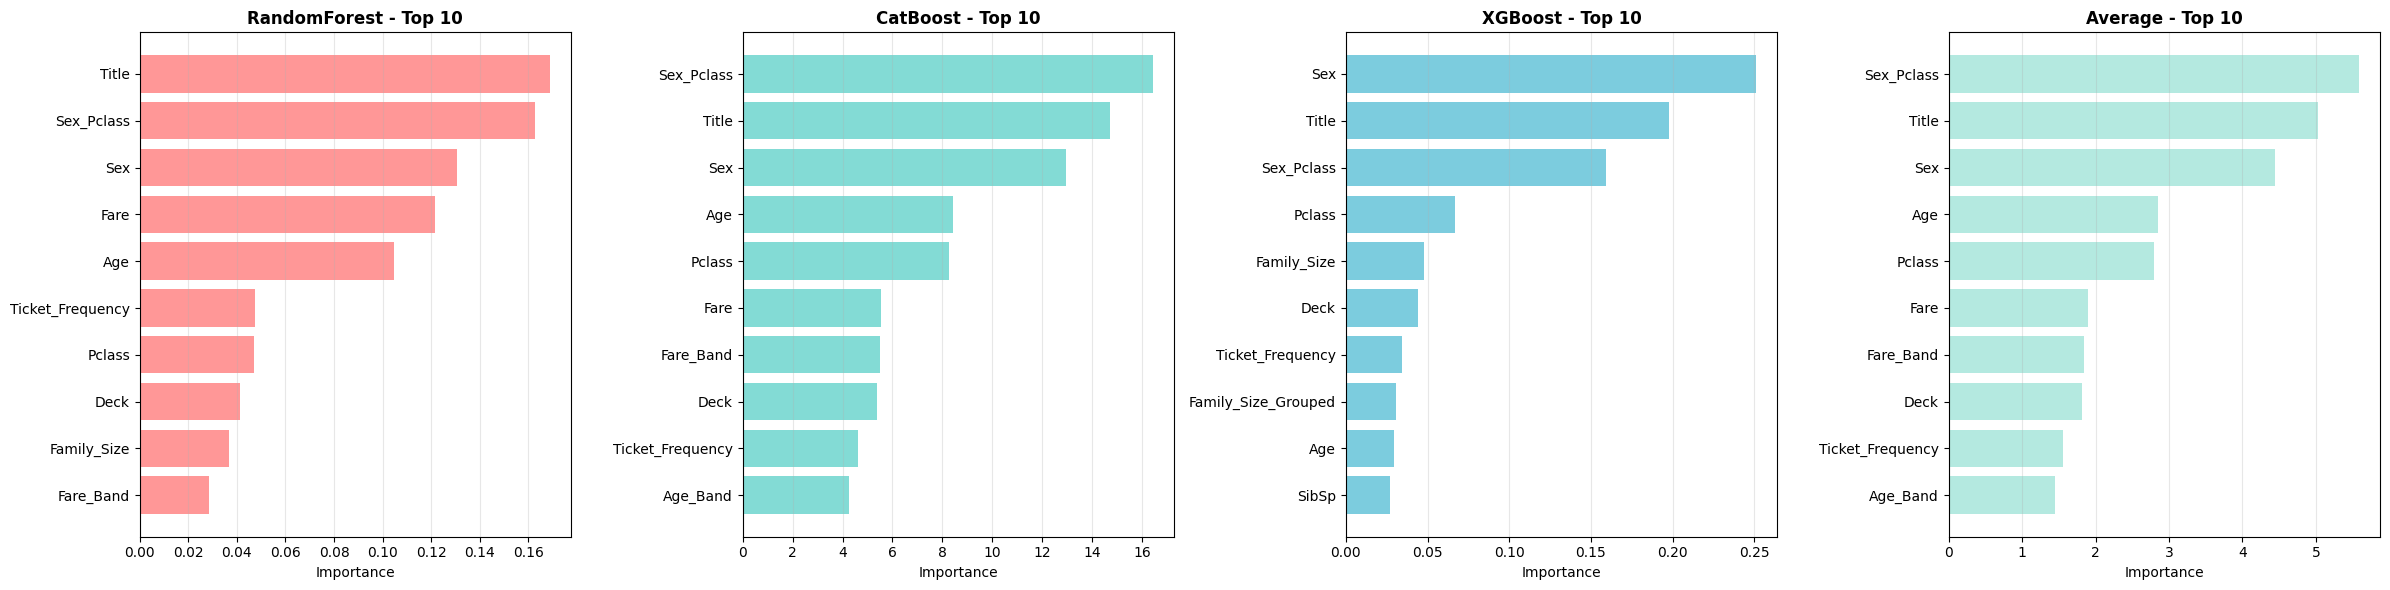


Feature Importance plot saved: ../output/feature_importance_top3.png


In [12]:
# Feature Importance可視化

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for idx, (col, title, color) in enumerate(zip(
    ['rf', 'cat', 'xgb', 'avg'],
    ['RandomForest', 'CatBoost', 'XGBoost', 'Average'],
    ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3']
)):
    top10 = df_fi.nlargest(10, col)
    axes[idx].barh(range(len(top10)), top10[col].values, color=color, alpha=0.7)
    axes[idx].set_yticks(range(len(top10)))
    axes[idx].set_yticklabels(top10['feature'].values)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{title} - Top 10', fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/feature_importance_top3.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature Importance plot saved: ../output/feature_importance_top3.png")

In [13]:
print("\n" + "="*60)
print("すべての処理が完了しました!")
print("="*60)
print(f"\n最終結果:")
print(f"  RandomForest OOF: {accuracy_score(y, results['oof_rf']):.4f}")
print(f"  CatBoost OOF:     {accuracy_score(y, results['oof_cat']):.4f}")
print(f"  XGBoost OOF:      {accuracy_score(y, results['oof_xgb']):.4f}")
print(f"  Ensemble OOF:     {ensemble_oof_score:.4f}")
print(f"\n提出ファイル: {output_path}")
print(f"モデルファイル: {model_save_path}")


すべての処理が完了しました!

最終結果:
  RandomForest OOF: 0.8339
  CatBoost OOF:     0.8339
  XGBoost OOF:      0.8373
  Ensemble OOF:     0.8328

提出ファイル: ../output/submission_top3_ensemble.csv
モデルファイル: ../output/models_top3_ensemble.pkl


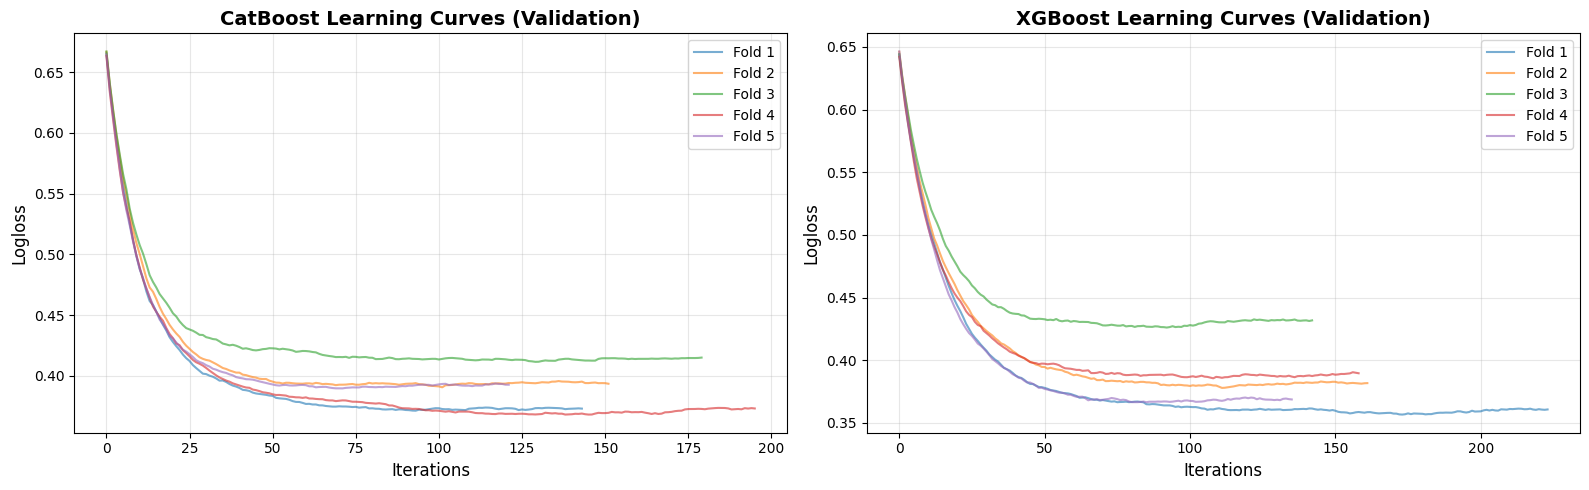

学習曲線を保存: ../output/learning_curves_top3.png


In [14]:
# 学習曲線の可視化（CatBoost & XGBoost）

# learning_curvesが存在するかチェック
if 'learning_curves' not in results:
    print("⚠️ 学習曲線データがありません。")
    print("セル10（学習実行）を再実行してください。")
    print("学習曲線データを取得するには、train_top3_models関数を再実行する必要があります。")
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # CatBoost学習曲線
    ax = axes[0]
    for fold_idx, evals_result in enumerate(results['learning_curves']['cat']):
        if 'validation' in evals_result:
            valid_loss = evals_result['validation']['Logloss']
            iterations = range(len(valid_loss))
            ax.plot(iterations, valid_loss, alpha=0.6, label=f'Fold {fold_idx+1}')
    
    ax.set_xlabel('Iterations', fontsize=12)
    ax.set_ylabel('Logloss', fontsize=12)
    ax.set_title('CatBoost Learning Curves (Validation)', fontweight='bold', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    
    # XGBoost学習曲線
    ax = axes[1]
    for fold_idx, evals_result in enumerate(results['learning_curves']['xgb']):
        if 'validation_1' in evals_result:
            valid_loss = evals_result['validation_1']['logloss']
            iterations = range(len(valid_loss))
            ax.plot(iterations, valid_loss, alpha=0.6, label=f'Fold {fold_idx+1}')
    
    ax.set_xlabel('Iterations', fontsize=12)
    ax.set_ylabel('Logloss', fontsize=12)
    ax.set_title('XGBoost Learning Curves (Validation)', fontweight='bold', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../output/learning_curves_top3.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("学習曲線を保存: ../output/learning_curves_top3.png")